# Time series

Time series data is data $f(t)$ where $t = time$. Given $f(t), t = 0, 1, ...n$, we want to predict the future. To do forecasting, we need the time series to be stationary process. 

This means that instead of purely caring about correlations along the rows (correlations between features dictating outputs) we now for the first time **care about correlation in the columns** (autocorrelation).

NOTE: It's hard to get comprehensive time series books I like, even 70 years into it. My favorite resource is the Master's level course [STAT 510](https://online.stat.psu.edu/stat510/lesson/1) by Penn State. The code is in R, but you can translate it to python as needed.

Case in point: this dataset is a single column.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df = pd.read_csv(
    'data/AirPassengers.csv',  index_col='month',  
    parse_dates = ['month'], date_parser = dateparse)
df.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Note the index isn't a `RangeIndex` ($0, 1, ...n$) it's a `DateTimeIndex` (date objects) which means the `[]` operator doesn't work the way you'd expect:

Note the index column isn't a `RangeIndex`, it's a `DateTimeIndex`

In [2]:
df['1949']

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


# Stationarity

A stationary process has:

* Mean = constant over all intervals.

* Variance = constant over all intervals.

![](unit_root.png)

This is important because it ensures predictable behavior that lets us model the time series properly. Modelling series with unit roots leads to spurious correlations (fake R^2)

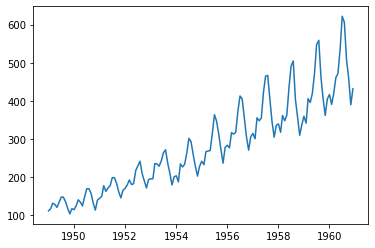

In [3]:
plt.plot(df)

Stationarity is defined using very strict criterion. H

owever, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

* Constant mean
* Constant variance
* An autocovariance that does not depend on time.

**Plotting Rolling Statistics:** We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant `t`, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

**Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the `Test Statistic` is less than the `Critical Value`, we can reject the null hypothesis and say that the series is stationary.

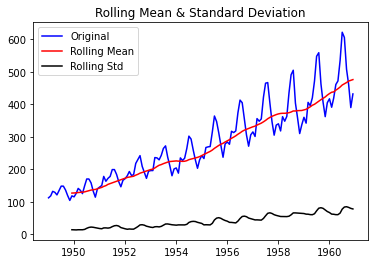

Results of Dickey-Fuller Test:


Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

In [4]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

test_stationarity(df)

Therefore, the time series is not stationary.

Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. **Trend** – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. **Seasonality** – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.

To eliminate **trend** we will apply a transformation that makes the values more or less same, ie. we use log

# Trend Stationary

One way to reduce a time series to a stationary format is to remove the time trend. This only works if the time series is trend stationary.

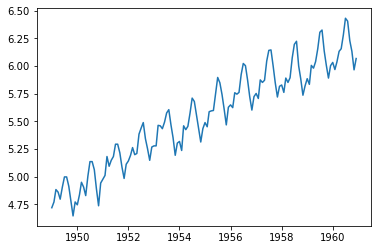

In [5]:
ts_log = np.log(df)
plt.plot(ts_log)

We will deal with the noise by taking rolling mean i.e. smoothing

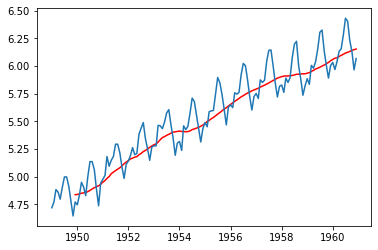

In [6]:
ts_smooth = ts_log.rolling(window = 12).mean()
plt.plot(ts_smooth, color = 'red')
plt.plot(ts_log)
plt.show()

In [7]:
# Case 1: No subtraction
no_sub_ts = ts_smooth
no_sub_ts.dropna(inplace = True)

# Case 2: Yes subtraction
sub_ts = ts_log - ts_smooth
sub_ts.dropna(inplace = True)

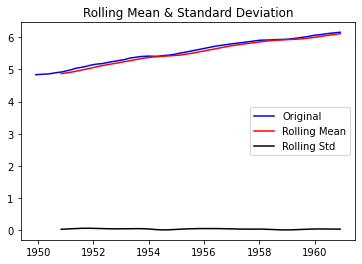

Results of Dickey-Fuller Test:


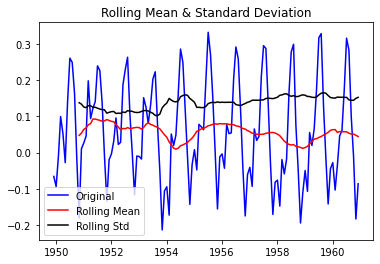

Results of Dickey-Fuller Test:


Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

In [8]:
# Perform Dickey-Fuller on both
test_stationarity(no_sub_ts)
test_stationarity(sub_ts)

Exponential weighted average instead of rolling average

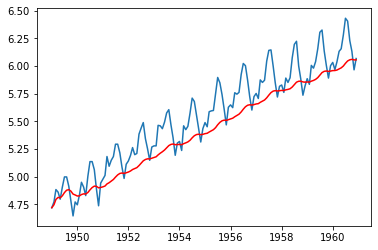

In [9]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

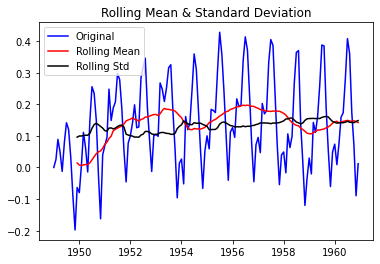

Results of Dickey-Fuller Test:


Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64

In [10]:
exp_ts_diff = ts_log-expwighted_avg
test_stationarity(exp_ts_diff)

Since test statistic is lower than 1% critical value, it means that we are 99% sure that we have a stationary series.

Other ways of eliminating trend and seasonality,
* Differencing
* Decomposition

# Differencing



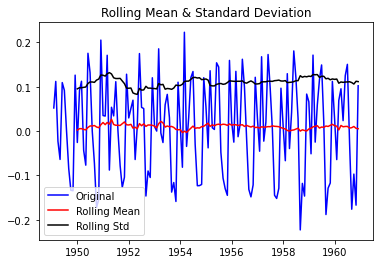

Results of Dickey-Fuller Test:


Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64

In [11]:
ts_diff = ts_log - ts_log.shift()
ts_diff.dropna(inplace = True)

test_stationarity(ts_diff)

How about differencing + exponential weighting?

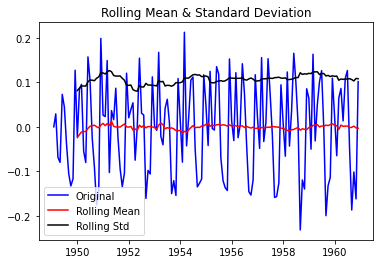

Results of Dickey-Fuller Test:


Test Statistic                  -4.067811
p-value                          0.001094
#Lags Used                      13.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64

In [12]:
ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
ts_diff_exp.dropna(inplace = True)
test_stationarity(ts_diff_exp)

Great! We got confidence of 99%. 

** Decomposition **

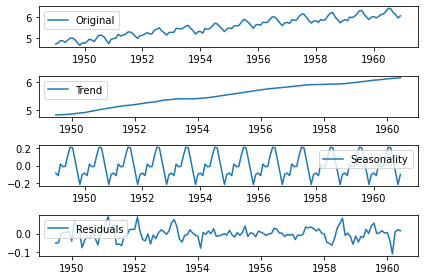

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

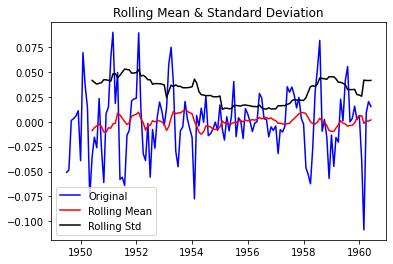

Results of Dickey-Fuller Test:


Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64

In [14]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [15]:
lf = df.reset_index()
lf['lag1'] = lf.passengers.shift(1)
lf['lag2'] = lf.passengers.shift(2)
lf['lag3'] = lf.passengers.shift(3)
lf = lf.iloc[3:]
lf

,month,passengers,lag1,lag2,lag3
3,1949-04-01,129,132.0,118.0,112.0
4,1949-05-01,121,129.0,132.0,118.0
5,1949-06-01,135,121.0,129.0,132.0
6,1949-07-01,148,135.0,121.0,129.0
7,1949-08-01,148,148.0,135.0,121.0
...,...,...,...,...,...
139,1960-08-01,606,622.0,535.0,472.0
140,1960-09-01,508,606.0,622.0,535.0
141,1960-10-01,461,508.0,606.0,622.0
142,1960-11-01,390,461.0,508.0,606.0


In [16]:
import statsmodels.api as sm
lf = lf.iloc[3:] # Remove first 3 observations (NaNs)
sm.OLS(lf.passengers, sm.add_constant(lf[['lag1', 'lag2', 'lag3']])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             passengers   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     584.2
Date:                Sat, 10 Apr 2021   Prob (F-statistic):           9.99e-77
Time:                        08:22:41   Log-Likelihood:                -671.12
No. Observations:                 138   AIC:                             1350.
Df Residuals:                     134   BIC:                             1362.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2842      7.248      1.971      0.051      -0.051      28.620
lag1           1.3476      0.086     15.606      0.000       1.177       1.518
lag2          -0.5904      0.139     -4.241      0.000      -0.866      -0.315
lag3           0.1991      0.088      2.271      0.025       0.026       0.373
==============================================================================
Omnibus:                        2.496   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.287   Jarque-Bera (JB):                2.238
Skew:                           0.311   Prob(JB):                        0.327
Kurtosis:                       3.037   Cond. No.                     1.42e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Spurious correlation!

Since we didn't have a stationary model, we get a spurious correlation in the AR model.

The R2 is fictitious -- it's picking up the unit root as if it were real correlation.

This will also happen if we model in a linear time trend specifically:

In [17]:
lf['trend'] = range(len(lf))
sm.OLS(lf.passengers, sm.add_constant(lf[['lag1', 'lag2', 'lag3', 'trend']])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             passengers   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     596.3
Date:                Sat, 10 Apr 2021   Prob (F-statistic):           7.39e-84
Time:                        08:22:43   Log-Likelihood:                -650.67
No. Observations:                 138   AIC:                             1311.
Df Residuals:                     133   BIC:                             1326.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.3858      7.862      5.900      0.000      30.835      61.937
lag1           1.0488      0.087     12.083      0.000       0.877       1.220
lag2          -0.4043      0.124     -3.272      0.001      -0.649      -0.160
lag3          -0.1082      0.088     -1.224      0.223      -0.283       0.067
trend          1.2650      0.187      6.773      0.000       0.896       1.634
==============================================================================
Omnibus:                        2.105   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.349   Jarque-Bera (JB):                1.715
Skew:                           0.262   Prob(JB):                        0.424
Kurtosis:                       3.151   Cond. No.                     1.80e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
df

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


# Model Validation on time series

Time series is the classical case where `train_test_split` fails. We need to split the data according to time. There are a few methods:

1) Test period at the end of the dataset

2) Backtesting. This can be done with a "rolling window" (slide a training window of fixed size across the dataset) or with a "recursive window" (increase training length on subsequent model runs)

We'll see that while modelling the unit root directly gives a great R2, this is spurious because it fails to forecase out of sample:

/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


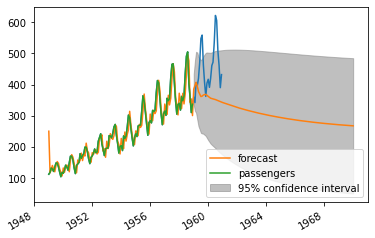

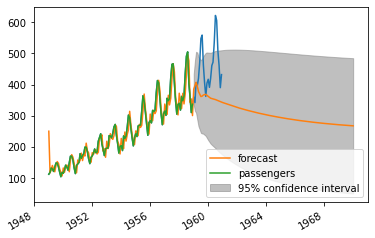

In [29]:
from statsmodels.tsa.arima_model import ARIMA
df_train = df.iloc[:-24]
df_test = df.iloc[-24:]

model = ARIMA(df_train, order=(7, 0, 0))  
res = model.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(df)

res.plot_predict('1949', '1970', ax=ax)

# Modelling on differenced series

So we need to model the differenced process:

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             passengers   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     6.669
Date:                Sat, 10 Apr 2021   Prob (F-statistic):           9.87e-07
Time:                        08:34:35   Log-Likelihood:                -653.14
No. Observations:                 136   AIC:                             1322.
Df Residuals:                     128   BIC:                             1346.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5413      2.700      1.682      0.095      -0.800       9.883
lag1           0.2825      0.088      3.206      0.002       0.108       0.457
lag2          -0.2589      0.092     -2.803      0.006      -0.442      -0.076
lag3          -0.1253      0.095     -1.313      0.191      -0.314       0.063
lag4          -0.3316      0.095     -3.509      0.001      -0.519      -0.145
lag5           0.0333      0.099      0.337      0.736      -0.162       0.228
lag6          -0.1660      0.096     -1.724      0.087      -0.357       0.025
lag7          -0.1612      0.094     -1.708      0.090      -0.348       0.026
==============================================================================
Omnibus:                        5.803   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                5.303
Skew:                           0.436   Prob(JB):                       0.0705
Kurtosis:                       3.420   Cond. No.                         48.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

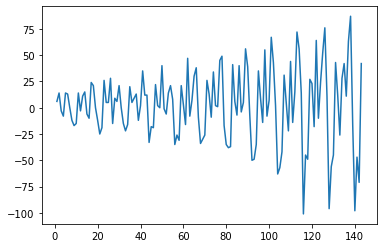

In [30]:
lf = df.reset_index()
lf.passengers -= lf.passengers.shift() # differencing
lf['lag1'] = lf.passengers.shift(1)
lf['lag2'] = lf.passengers.shift(2)
lf['lag3'] = lf.passengers.shift(3)
lf['lag4'] = lf.passengers.shift(4)
lf['lag5'] = lf.passengers.shift(5)
lf['lag6'] = lf.passengers.shift(6)
lf['lag7'] = lf.passengers.shift(7)
plt.plot(lf.passengers)
lf = lf.iloc[8:]
sm.OLS(lf.passengers, sm.add_constant(lf[['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7']])).fit().summary()

The R2 is worse (0.24 versus 0.94 on the raw series) but the out of sample prediction will now be good.

We'll used `ARIMA` to plot it. Here, the `AR` parameter is the number of lags, and the `I` parameter is the "integration" (number of times we difference the series):

/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


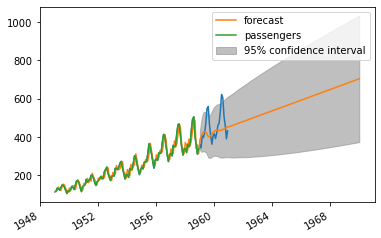

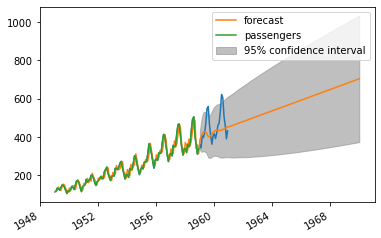

In [31]:
model = ARIMA(df_train, order=(7, 1, 0))  
res = model.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(df)
res.plot_predict('1949', '1970', ax=ax)

Modelling on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

1. A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
2. A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

# ARIMA

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

1. Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.



**Selecting p, q, and d values**
1. Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.


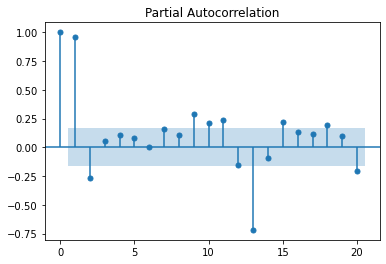

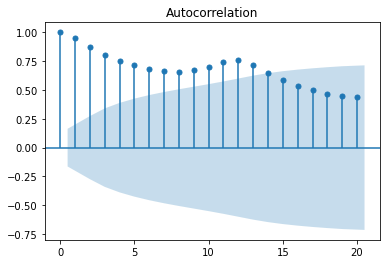

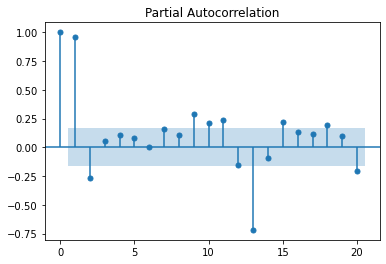

In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df, lags=20)
plot_pacf(df, lags=20)

Note that the ACF on the raw time series is spurious! We need to difference the series to get the real ACF:

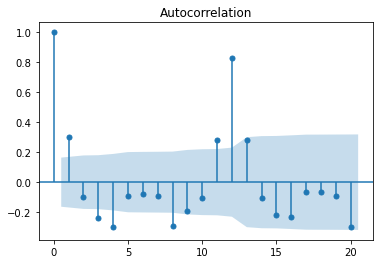

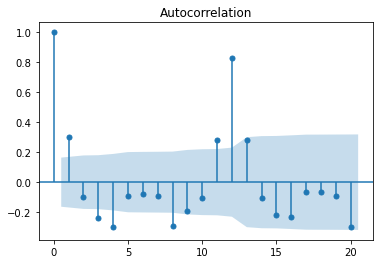

In [37]:
plot_acf((df - df.shift())[1:], lags=20)

So lags 1,2,4,13,14 are statistically coherent in the ACF, but in the PACF we see that lags 1 and 2 explain most of it.

We'll model ARIMA with:

`p = 2, q = 2`

as a starter point, though it's common to gridsearch ARIMA models in practice (minimizing the AIC or BIC):

/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


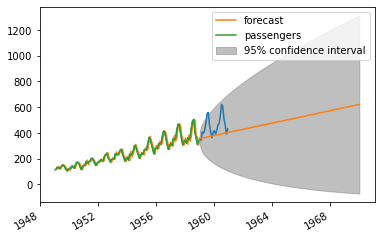

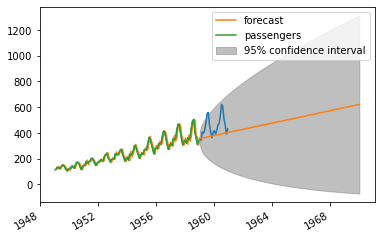

In [40]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df_train, order=(2, 1, 0))  
res = model.fit(disp=-1)  
fig, ax = plt.subplots()
ax.plot(df)
res.plot_predict('1949', '1970', ax=ax)

/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


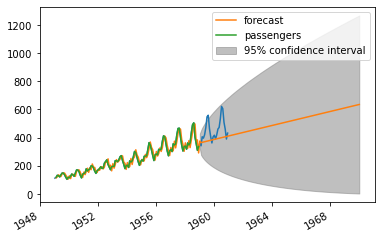

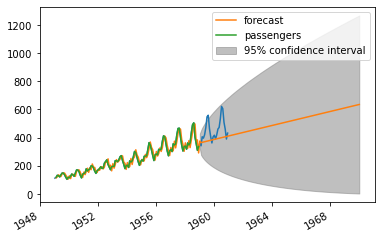

In [41]:
# MA model

model = ARIMA(df_train, order=(0, 1, 2))  
res = model.fit(disp=-1)  
fig, ax = plt.subplots()
ax.plot(df)
res.plot_predict('1949', '1970', ax=ax)

/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


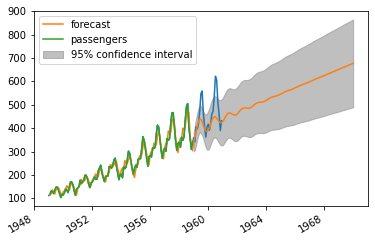

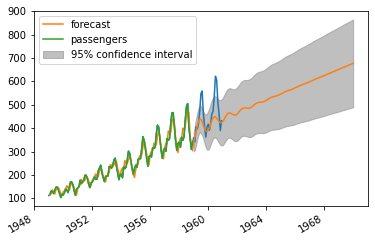

In [49]:
# ARIMA model

model = ARIMA(df_train, order=(2, 1, 2))  
res = model.fit()  
fig, ax = plt.subplots()
ax.plot(df)
res.plot_predict('1949', '1970', ax=ax)

# Modelling with Seasonality

The `SARIMAX` model ([see here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)) lets you model in exogenous data and cyclic components directly.

For today we'll only see the cyclic component, which is modelled in the `seasonal_order` (p, d, q, S) with seasonality `S`. **NOTE** This first an ARIMA over the cyclic component, so be conservative with cyclic order components.

/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/mranger/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
                                      SARIMAX Results                                      
Dep. Variable:                          passengers   No. Observations:                  120
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                -456.110
Date:                             Sat, 10 Apr 2021   AIC                            924.220
Time:                                     08:53:56   BIC                            940.895
Sample:                                 01-01-1949   HQIC                           930.991
                                

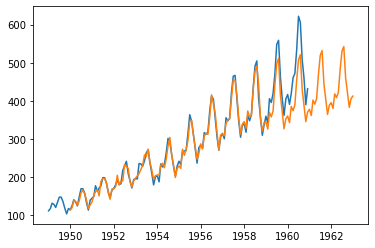

In [68]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(
    df_train, order=(2,1,2), seasonal_order=(1,0,0,12))
res = mod.fit(disp=False)
print(res.summary())
fig, ax = plt.subplots()
ax.plot(df)
ax.plot(res.predict('1950', '1963'))